In [1]:
source(file.path("..", "R", "init.R"))
init(where = "container")

suppressMessages({
  library(dplyr)
  library(ggplot2)
  library(reticulate)
  library(lhs)
  library(future.apply)
  library(future)
  library(parallel)
})

[1] "Config for container!"


# Generate samples ("LHS" or "FAST")

### Problem

In [2]:
source("problem.R")
problem

$num_vars
[1] 19

$names
 [1] "phen_VegTherTimeResp_X3"   "phen_RepTherTimeResp_X3"  
 [3] "phen_VegPhoMod_X1"         "phen_RepPhoMod_X1"        
 [5] "phen_VegetativeTarget"     "phen_EarlyFloweringTarget"
 [7] "phen_EarlyPodDevTarget"    "phen_FractGrainFill"      
 [9] "phen_EntGrainFill"         "phen_MidGrainFill"        
[11] "phen_Maturing"             "phen_Ripening"            
[13] "phen_shootlag"             "phen_shootrate"           
[15] "leaf_RUE"                  "leaf_AreaLargLeaf"        
[17] "leaf_Phyllochron"          "leaf_ExtinctionCoef_Y1"   
[19] "grain_HarvIndex"          

$bounds
$bounds[[1]]
[1] 21 39

$bounds[[2]]
[1] 21 39

$bounds[[3]]
[1] 11.5 17.3

$bounds[[4]]
[1] 11.5 17.3

$bounds[[5]]
[1] 140 260

$bounds[[6]]
[1] 100 300

$bounds[[7]]
[1]  70 210

$bounds[[8]]
[1] 0.035 0.065

$bounds[[9]]
[1] 250 750

$bounds[[10]]
[1] 0.25 0.75

$bounds[[11]]
[1] 22.5 67.5

$bounds[[12]]
[1] 31.5 58.5

$bounds[[13]]
[1]  5 15

$bounds[[14]]
[1] 0.5 1.5

$bounds[[15]]
[1] 0.84 1.56

$bounds[[16]]
[1] 0.004 0.008

$bounds[[17]]
[1] 31.5 58.5

$bounds[[18]]
[1] 0.42 0.78

$bounds[[19]]
[1] 0.25 0.75

### Generate samples

In [4]:
# method = "LHS"
method = "FAST"
# method = "SOBOL"

N_SAMPLES = 500L

set.seed(1111)

if (method == "LHS") {
  convert_row_to_var_bounds <- function(row) {
    for (i in 1:length(row)) {
      lb <- variable_bounds[[i]][1]
      ub <- variable_bounds[[i]][2]
      range <- ub - lb
      row[i] <- lb + row[i] * range
    }
    return(row)
  }
  N_VARS <- as.integer(problem$num_vars)
  # df_samples_norm <- import("scipy.stats.qmc")$LatinHypercube(d = N_VARS)$random(n = N_SAMPLES)
  df_samples_norm <- randomLHS(N_SAMPLES, N_VARS)
  # Convert df to var bounds
  for (i in 1:nrow(df_samples_norm)) {
    df_samples_norm[i, ] <- convert_row_to_var_bounds(df_samples_norm[i, ])
  }
  samples <- df_samples_norm
} else if (method == "FAST") {
  sampler <- reticulate::import("SALib.sample.fast_sampler")
  samples <- sampler$sample(problem, N_SAMPLES)
} else if (method == "SOBOL") {
  sampler <- reticulate::import("SALib.sample.sobol")
  samples <- sampler$sample(problem, N_SAMPLES, calc_second_order = TRUE)
} else {
  stop("invalid option! Available: LHS, FAST and SOBOL")
}
head(samples)

samples_df <- as.data.frame(samples) %>%
  `colnames<-`(problem$names) %>%
  dplyr::mutate(id = as.integer(rownames(.))) %>%
  dplyr::select(id, everything())
dim(samples_df)
head(samples_df)

write.csv(samples_df, "samples.csv", row.names = FALSE)

23.30812,34.74734,15.97337,13.41882,174.0991,121.3791,121.53286,0.05989156,368.1519,0.4353162,30.79367,51.47029,5.299220,0.7750830,0.979317,0.005491025,41.31614,0.6530300,0.2517666
32.47954,27.60291,14.66700,16.19645,157.0257,210.1897,82.53922,0.06003019,649.4294,0.3236074,40.12475,35.03872,7.560711,1.2543114,1.213899,0.007382372,45.98210,0.6667422,0.7436701
26.71961,27.99023,14.31564,12.94032,163.9516,170.5732,99.47784,0.04689631,267.8029,0.3097320,25.52204,42.19595,9.452906,0.7644285,1.062359,0.007436123,40.71927,0.5173735,0.6783468
21.03678,38.60296,14.50800,14.14167,160.0459,175.3104,140.94319,0.05417644,731.7443,0.5399398,44.76482,35.56882,13.980905,1.4834298,1.030448,0.004383356,36.26197,0.6185954,0.2556975
25.82531,35.25609,17.08741,15.84953,195.2882,227.8158,157.35645,0.05262079,365.0472,0.3912136,45.35587,47.97679,7.984151,0.5534283,1.530831,0.007608807,36.19417,0.6542598,0.2876957
34.68565,34.97611,14.70147,16.89733,211.0772,262.2131,110.73994,0.05434468,505.4250,0.5935311,47.26966,33.10265,10.331718,1.2714874,1.408055,0.006769994,41.72700,0.5620730,0.4547037


[1] 5000   20

,id,phen_VegTherTimeResp_X3,phen_RepTherTimeResp_X3,phen_VegPhoMod_X1,phen_RepPhoMod_X1,phen_VegetativeTarget,phen_EarlyFloweringTarget,phen_EarlyPodDevTarget,phen_FractGrainFill,phen_EntGrainFill,phen_MidGrainFill,phen_Maturing,phen_Ripening,phen_shootlag,phen_shootrate,leaf_RUE,leaf_AreaLargLeaf,leaf_Phyllochron,leaf_ExtinctionCoef_Y1,grain_HarvIndex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,23.30812,34.74734,15.97337,13.41882,174.0991,121.3791,121.53286,0.05989156,368.1519,0.4353162,30.79367,51.47029,5.299220,0.7750830,0.979317,0.005491025,41.31614,0.6530300,0.2517666
2,2,32.47954,27.60291,14.66700,16.19645,157.0257,210.1897,82.53922,0.06003019,649.4294,0.3236074,40.12475,35.03872,7.560711,1.2543114,1.213899,0.007382372,45.98210,0.6667422,0.7436701
3,3,26.71961,27.99023,14.31564,12.94032,163.9516,170.5732,99.47784,0.04689631,267.8029,0.3097320,25.52204,42.19595,9.452906,0.7644285,1.062359,0.007436123,40.71927,0.5173735,0.6783468
4,4,21.03678,38.60296,14.50800,14.14167,160.0459,175.3104,140.94319,0.05417644,731.7443,0.5399398,44.76482,35.56882,13.980905,1.4834298,1.030448,0.004383356,36.26197,0.6185954,0.2556975
5,5,25.82531,35.25609,17.08741,15.84953,195.2882,227.8158,157.35645,0.05262079,365.0472,0.3912136,45.35587,47.97679,7.984151,0.5534283,1.530831,0.007608807,36.19417,0.6542598,0.2876957
6,6,34.68565,34.97611,14.70147,16.89733,211.0772,262.2131,110.73994,0.05434468,505.4250,0.5935311,47.26966,33.10265,10.331718,1.2714874,1.408055,0.006769994,41.72700,0.5620730,0.4547037


# Open samples and plot distribution

[1] 16000    17

,id,phen_VegTherTimeResp_X3,phen_RepTherTimeResp_X3,phen_VegPhoMod_X1,phen_RepPhoMod_X1,phen_VegetativeTarget,phen_EarlyFloweringTarget,phen_EarlyPodDevTarget,phen_FractGrainFill,phen_EntGrainFill,phen_Maturing,phen_Ripening,leaf_RUE,leaf_AreaLargLeaf,leaf_Phyllochron,leaf_ExtinctionCoef_Y1,grain_HarvIndex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,24.15602,24.15602,12.51694,12.51694,161.0401,161.0401,112.7281,0.04026003,402.6003,36.23403,36.23403,0.9662408,0.004701338,36.23403,0.4831204,0.4026003
2,2,28.62002,24.19202,12.54014,12.55174,162.0001,162.2401,113.7361,0.04068003,407.4003,36.72003,36.77403,0.9820808,0.004797338,36.93603,0.4932004,0.4116003
3,3,33.08402,24.22802,12.56334,12.58654,162.9601,163.4401,114.7441,0.04110003,412.2003,37.20603,37.31403,0.9979208,0.004893338,37.63803,0.5032804,0.4206003
4,4,37.54802,24.26402,12.58654,12.62134,163.9201,164.6401,115.7521,0.04152003,417.0003,37.69203,37.85403,1.0137608,0.004989338,38.34003,0.5133604,0.4296003
5,5,35.98798,24.30002,12.60974,12.65614,164.8801,165.8401,116.7601,0.04194003,421.8003,38.17803,38.39403,1.0296008,0.005085338,39.04203,0.5234404,0.4386003
6,6,31.52398,24.33602,12.63294,12.69094,165.8401,167.0401,117.7681,0.04236003,426.6003,38.66403,38.93403,1.0454408,0.005181338,39.74403,0.5335204,0.4476003


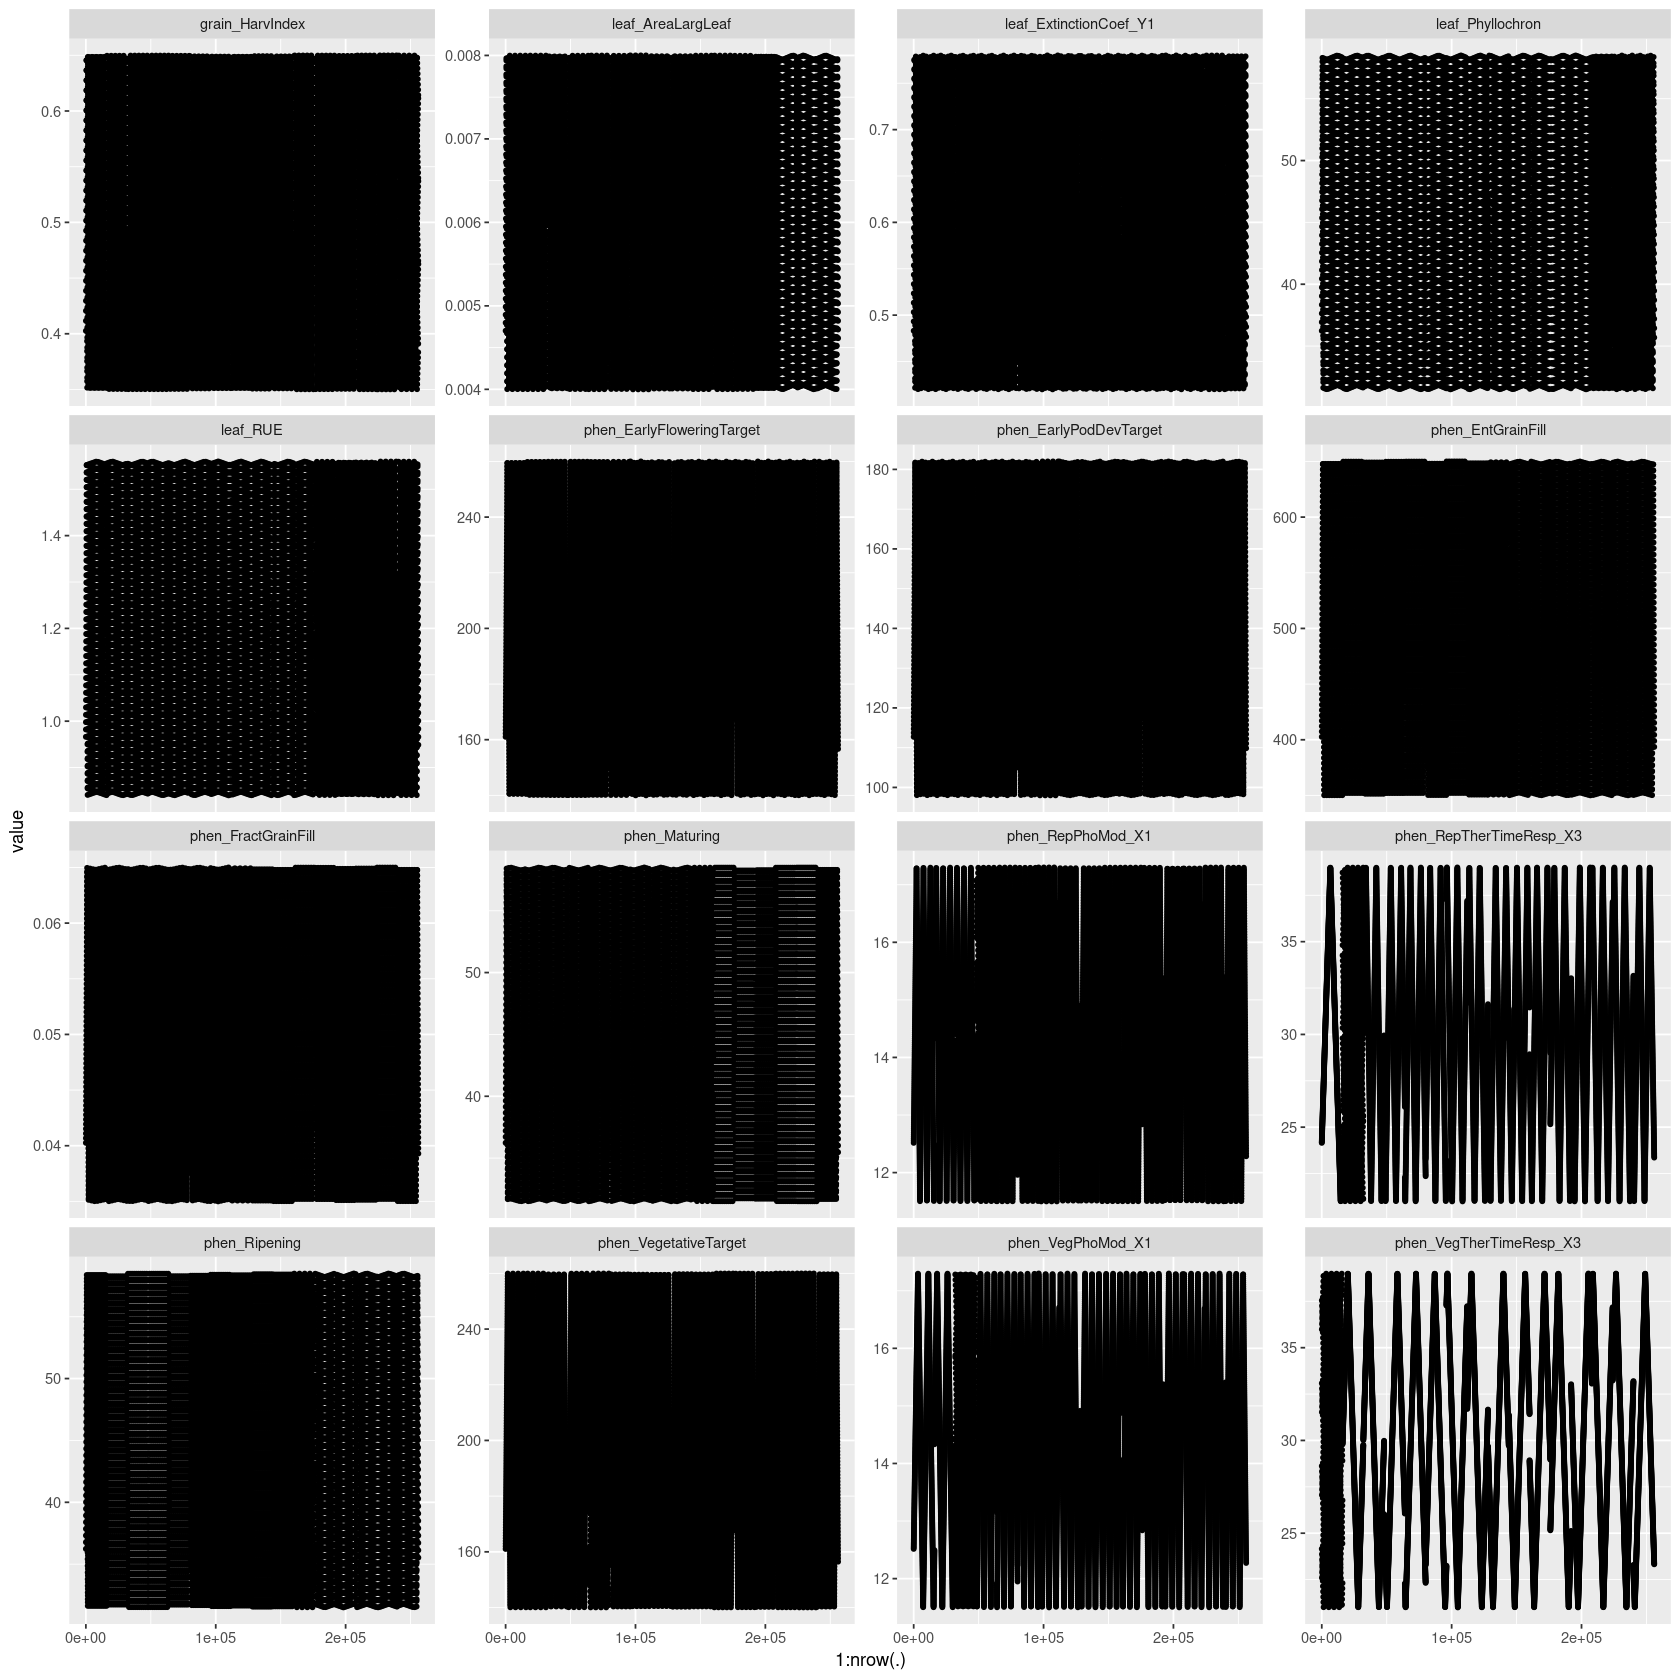

In [2]:
samples_filepath <- "samples.csv"
samples_df <- read.csv(samples_filepath) %>%
  select(id, everything())
dim(samples_df)
head(samples_df)

options(repr.plot.width = 14, repr.plot.height = 14)
samples_df %>%
  tidyr::pivot_longer(cols = -id, names_to = "variable", values_to = "value") %>%
  ggplot(aes(x = 1:nrow(.), y = value)) +
    facet_wrap(variable ~ ., scale = "free_y") +
    geom_point(size = 1)

# Generate apsimx files

In [4]:
sensi_tmp_folder <- create_tmp_dir_from_base_folder("tmp_sensi_5")
sensi_tmp_folder

Warning message in create_tmp_dir(folder_path = folder_filepath, copy_met_data = copy_met_data):
“/home/rstudio/apsimtestes/tmp_sensi6 folder already exists! 
Please make sure the folder name is correct in order not to overwrite important runs!”


[1] "/home/rstudio/apsimtestes/tmp_sensi6"

# WARNING: CHECK BASESIM FILEPATH BELOW
# WARNING: CHECK BASESIM FILEPATH BELOW
# WARNING: CHECK BASESIM FILEPATH BELOW

In [1]:
generate_apsimx_from_df(
  samples_df = samples_df,
  folder = sensi_tmp_folder,
  # sensit_base_sim_filepath = file.path(getwd(), "Soy-BR-sensit.apsimx"),
  # sensit_base_sim_filepath = file.path(BASE_SIMULATIONS_FOLDER, "Soy-BR-fields-MG6.apsimx"),
  sensit_base_sim_filepath = file.path(BASE_SIMULATIONS_FOLDER, "Soy-BR-fields-MG06BR_replac.apsimx.apsimx"),
  runs_only_some = FALSE,
  parallel = FALSE
)

ERROR: Error in generate_apsimx_from_df(samples_df = samples_df, folder = sensi_tmp_folder, : could not find function "generate_apsimx_from_df"


In [7]:
# Check number of csvs Report in folder
paste("Number of csvs:", length(list.files(sensi_tmp_folder, pattern = "HarvestReport")))

# Check number of apsimx in folder
apsimx_filepaths <- list.files(sensi_tmp_folder, pattern = ".apsimx", full.names = TRUE)
paste("Number of apsimxs:", length(apsimx_filepaths))
apsimx_filepaths[1:5]

# IDS_TO_RUN <- c(1, 1000, 1001, 1004, 101)
# apsimx_filepaths <- apsimx_filepaths[grepl(paste0("n",IDS_TO_RUN,".a", collapse = "|"), apsimx_filepaths)]
# length(apsimx_filepaths)
# apsimx_filepaths[1:5]

[1] "Number of csvs: 1"

[1] "Number of apsimxs: 15"

[1] "/home/rstudio/apsimtestes/tmp_sensi6/simulation1.apsimx" 
[2] "/home/rstudio/apsimtestes/tmp_sensi6/simulation10.apsimx"
[3] "/home/rstudio/apsimtestes/tmp_sensi6/simulation11.apsimx"
[4] "/home/rstudio/apsimtestes/tmp_sensi6/simulation12.apsimx"
[5] "/home/rstudio/apsimtestes/tmp_sensi6/simulation13.apsimx"

# Run all apsimx from folder

In [8]:
run_apsimx_from_folder(
  folder = sensi_tmp_folder,
  force = FALSE,
  runs_only_some = FALSE,
  parallel = FALSE
)

[1] "file /home/rstudio/apsimtestes/tmp_sensi6/simulation1.DailyReport.csv exists! Returning..."
   user  system elapsed 
 25.570   1.049  24.939 
   user  system elapsed 
 25.711   1.119  26.605 
   user  system elapsed 
 23.264   0.957  21.591 
   user  system elapsed 
 22.503   0.940  20.620 
   user  system elapsed 
 22.601   0.752  20.471 
   user  system elapsed 
 22.556   0.918  20.698 
   user  system elapsed 
 25.356   1.048  24.762 
   user  system elapsed 
 25.891   0.955  26.945 
   user  system elapsed 
 22.900   0.999  21.527 
   user  system elapsed 
 22.538   0.926  20.611 
   user  system elapsed 
 22.500   0.904  20.462 
   user  system elapsed 
 22.552   0.818  20.574 
   user  system elapsed 
 18.638   0.768  16.352 
   user  system elapsed 
 18.424   0.633  16.077 


Warning message in system(command, intern = TRUE):
“running command '/usr/local/bin/Models /home/rstudio/apsimtestes/tmp_sensi6/simulation4.apsimx --csv --single-threaded=FALSE --cpu-count=2' had status 1”
Warning message in system(command, intern = TRUE):
“running command '/usr/local/bin/Models /home/rstudio/apsimtestes/tmp_sensi6/simulation7.apsimx --csv --single-threaded=FALSE --cpu-count=2' had status 1”
